In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC, ROCAUC

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None

In [2]:
Train = False # False if you do analysis with given simulations and estimates

In [3]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('module load python3.8-anaconda/2020.07', 
                       'source activate slim', 
                       '#time=0-0:10:00',
                       '#mem=1000M',
                       '#mem-per-cpu=None', 
                       '#job-name="sim"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=3')

### Parameters:

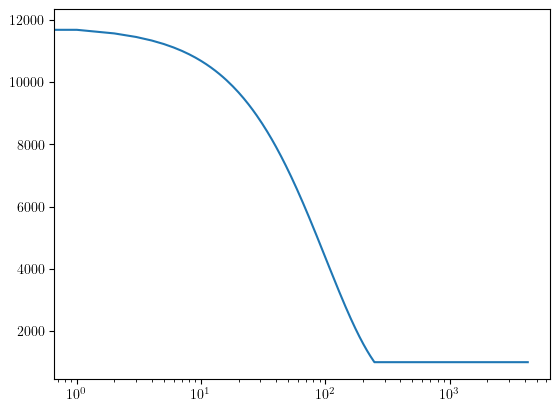

In [4]:
N = 250
Ne = 1000
L = 2500
r = 1.25e-7
mu = 2.5e-7

Ne0 = 500
h = 25
s = 0.02
gr = 0.01
rep = 1+gr

startexp = 4000
Until = 4250

eps = get_eps(Ne0, gr, Until, constant_gen = startexp)

#mtgs = Until-np.logspace(1, np.log(Until), 100, base = np.e).astype('int')
#mtgs = np.linspace(1, 1000, 100).astype('int')
#mtgs = np.r_[mtgs, np.linspace(6001, 8050, 50).astype('int')]
#mtgs = np.r_[mtgs, np.linspace(13001, 13050, 50).astype('int')]
#mtgs = Until-np.logspace(0, np.log(Until), 200, base = np.e).astype('int')

plt.plot(np.flip(eps))
plt.xscale('log')
plt.show()

In [5]:
Common = {'Simulator':'slim', 'slimTxt':'Constant_mt.txt', 
          'N':N, 'L':L, 'r':r, 'mu':mu,
          'Until':Until,
          'srun':srun, 'srun_est':srun_est}

nonsel = {'s':0, 'h':0.5, 'reset_lost': 0}
balsel = {'s':s/h, 'h':h, 'reset_lost': 1}

cnstP = {'Ne':Ne, 'start':Until+10, 'etapath':'etas/bcn2.json', 'rep':0, }
expgP = {'Ne':Ne0,'start': startexp, 'etapath':'etas/ben2.json', 'rep':rep}

In [89]:
Args = {}
# Args['bcn'] = {**Common, **nonsel, **cnstP, 'name':'Constant Population Size \nNeutral Mutation'}
# Args['ben'] = {**Common, **nonsel, **expgP, 'name':'Exponential Growth \nNeutral Mutation'}
# Args['bcs'] = {**Common, **balsel, **cnstP, 'name':'Constant Population Size \nBalancing Selection'}
# Args['bes'] = {**Common, **balsel, **expgP, 'name':'Exponential Growth \nBalancing Selection'}

Args['bcn'] = {**Common, **nonsel, **cnstP, 'name':'C/N'}
Args['ben'] = {**Common, **nonsel, **expgP, 'name':'E/N'}
Args['bcs'] = {**Common, **balsel, **cnstP, 'name':'C/B'}
Args['bes'] = {**Common, **balsel, **expgP, 'name':'E/B'}

In [7]:
cID = 4 # simulation class id for balancing selection exponential growth simulations
nrep = 250
X = Experiment(cID, nrep, Args)

## 1 Simulation

In [8]:
if Train:
    X.sim()

If you are using HPC (srun is not None) check the jobs!


## 2 Population Size History estimation

In [10]:
X.calc_sfs()
X.train_eta()

Done!


bcn 3788
ben 4653
bcs 4325
bes 5493


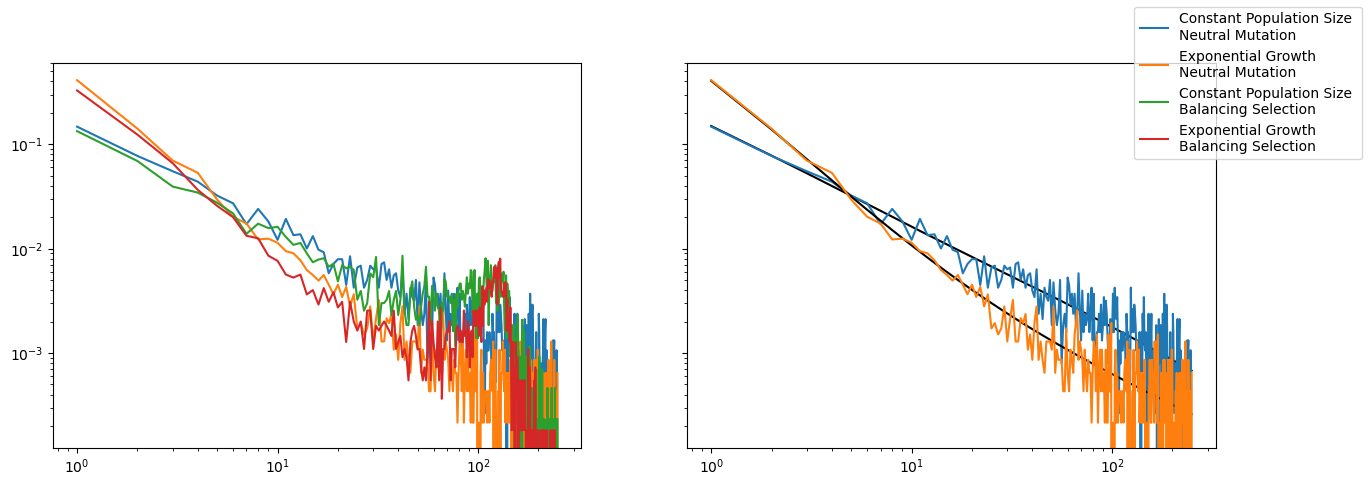

In [11]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())
    
for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())

ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend()

## 3 Optimizing $\beta$-imbalance and calculating summary stats

In [12]:
BIM = '/home/enes/bim/BIM.py'

estjobs = {}
if Train:
    for setid in X.setids:
        estjobs[setid] = X.est(BIM, setid, now = 20, srun = srun_est, arg = '--r2t=0.005 --r2s=0.001')

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [18]:
if Train:
    for setid in X.setids:
        X.merge_outs(setid)

## 4 Analysis

In [8]:
stats = ['bsfs', 'TajD']

### ROC Curves

In [91]:
Vs = [['bcn', 'bcs'],['ben', 'bes'],['bcn', 'bes']]

fprs = {}
tprs = {}
aucs = {}
blds = {}

for vs in Vs:
    k1, k2 = vs
    name = Args[k1]['name']+' vs '+Args[k2]['name']    
    
    df1 = pd.read_csv(X.df[k1])
    df2 = pd.read_csv(X.df[k2])  
    
    max_auc = 0
    for key in stats:  
        fpr, tpr, auc = ROCAUC(df1[key], df2[key], score_ascending = True)
        fprs[key, name] = fpr
        tprs[key, name] = tpr
        aucs[key, name] = auc
        
        if auc>max_auc:
            blds[name] = key
            max_auc = auc     

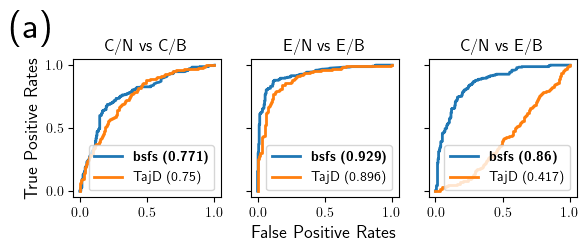

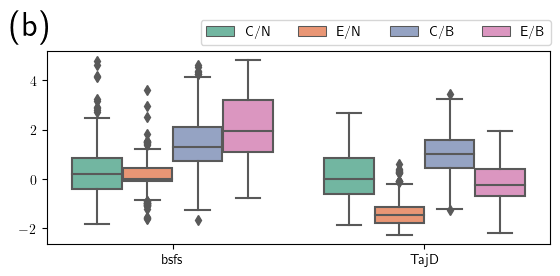

In [117]:
fig, ax = plt.subplots(1,3,figsize = (6.5,1.8), sharex = True, sharey = True)

for i, name in enumerate(blds):
    for key in stats:
        fpr = fprs[key, name]
        tpr = tprs[key, name]
        auc = aucs[key, name]
        
        label = key + ' ('+str(round(auc, 3))+')'      
        
        if blds[name] == key:
            label = r"\textbf{"+label+"}"
        
        ax[i].plot(fpr, tpr, label = label, linewidth = 2)
    ax[i].legend(loc = 'lower right', prop={'size': 10})   
    ax[i].set_title(name, size = 12)

fig.text(.062, 1.05, '(a)', ha='center', va='center', size = 27)
ax[1].set_xlabel('False Positive Rates', size = 13)
ax[0].set_ylabel('True Positive Rates', size = 13)
#plt.tight_layout()
plt.savefig('plots/Exponential_Balancing.pdf', dpi = 600, bbox_inches = 'tight')

dfs = []
for setid in X.setids:
    df = pd.read_csv(X.df[setid])[['path']+stats]
    df['setid'] = Args[setid]['name']
    dfs.append(df)
    
dfs = pd.concat(dfs)
dfs = dfs.melt(id_vars=['path', 'setid'], var_name='stats', value_name='values')

plt.figure(figsize = (6.5,2.5))

sns.boxplot(data=dfs, x='stats', y='values', hue='setid', palette='Set2')
plt.legend(loc='upper left', bbox_to_anchor=(0.292, 1.2), prop={'size': 10}, ncol = 4)
plt.xlabel('')
plt.ylabel('')

plt.text(-.562, 6.2, '(b)', ha='center', va='center', size = 25)
plt.savefig('plots/Exponential_Balancing_box.pdf', dpi = 600, bbox_inches = 'tight')